## Logistic Regression

A logistic regression classifier built using Python and Numpy to predict university admissions. Each observation contains an individual student's scores on two exams, as well as their admission decision (0 for rejection, 1 for acceptance).

Note: This is a sample problem from Andrew Ng's machine learning course, and no train/test split was used in order to match the expected output. In reality, we would typically split the data into a train set, dev set, and test set or use cross validation. Occasionally, a training-dev set may even be used as well.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [23]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def normalize(X, means=None, stds=None):
    """Pass in (m x n) dimensional X matrix and normalize each column. Return 
    the normalized X matrix and the column means and stdevs for future use.
    """
    if means is None and stds is None:
        means = X.mean(axis=0)
        stds = X.std(axis=0)
    X = (X - means) / stds
    return X, means, stds

In [3]:
def sigmoid(z):
    """Pass matrix z through sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

In [6]:
def cost(X, y, theta):
    """Calculate binary cross entropy loss for matrix X. X should include 
    x0 column of ones.
    """
    m = X.shape[0]
    h = sigmoid(X @ theta)
    j = -1/m * (y.T @ np.log(h) + (1 - y).T.dot(np.log(1 - h)))
    return j

In [126]:
def gradient_descent(X, y, theta, alpha, iters):
    """Pass in theta as matrix of zeros. Adjust theta values until the cost
    function is minimized. Return the optimal theta values, as well as the 
    cost value for each iteration.
    
    alpha : float
        Learning rate that determines the rate at which weights are updated.
    iters : int
        Number of epochs to run gradient descent.
    """
    m = X.shape[0]
    costs = []
    for i in range(iters):
        h = sigmoid(X @ theta)
        gradient = X.T @ (y - h)
        theta = theta + alpha * gradient
        costs.append(cost(X, y, theta))
        if i > 0 and np.isclose(costs[-1], costs[-2]):
            break
    return theta, costs

In [140]:
def predict(X, theta):
    """Pass in numpy array X, with scaled features and bias column. Return
    predicted probabilities and class assignments.
    """
    probs = sigmoid(X @ theta)
    preds = np.where(probs >= 0.5, 1, 0)
    return {'probs': probs, 'preds': np.array(preds)}

In [128]:
def scale_predict(X, means, stdevs, theta):
    """Pass in X and previously generated feature parameters for scaling. 
    Normalize features and add a bias column of ones. Use weights optimized 
    through gradient descent to predict probabilities and classes.
    """
    X = normalize(X, means, stdevs)[0]
    X = np.column_stack((np.ones(X.shape[0]), X))
    output_dict = predict(X, theta)
    return output_dict

## Load data

In [129]:
data = np.loadtxt('data/ex2data1.txt', delimiter=',')
print(data[:5,:])
print('\nData dimensions:', data.shape)
print('\nColumn means:\n{}'.format(data.mean(axis=0)))

# Split data into X and y
X = data[:,:-1]
y = data[:,-1]
m, n = X.shape

[[34.62365962 78.02469282  0.        ]
 [30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]]

Data dimensions: (100, 3)

Column means:
[65.64427406 66.22199809  0.6       ]


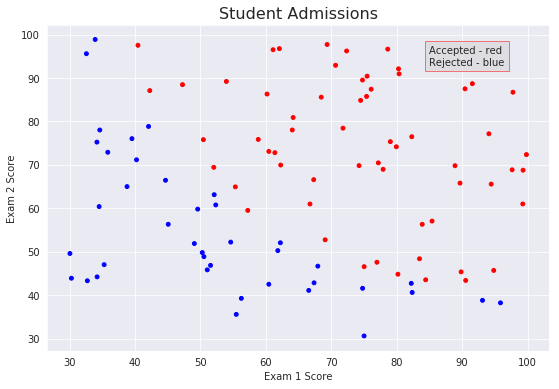

In [130]:
# Quick data visualization
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9,6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', s=15)
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.title('Student Admissions', fontsize=16)
plt.text(85,93, 'Accepted - red\nRejected - blue', bbox={'edgecolor': 'red', 
                                                        'facecolor': 'lightgrey',
                                                        'alpha': 0.5})
plt.show()

## Preprocessing

Perform feature scaling on X, using column mean and standard deviation to normalize the data. This should help gradient descent converge more quickly. 

In [131]:
X_scaled, col_means, col_stdevs = normalize(X)
X_scaled = np.column_stack((np.ones(m), X_scaled))
print(X_scaled[:5,:])

[[ 1.         -1.60224763  0.63834112]
 [ 1.         -1.82625564 -1.2075414 ]
 [ 1.         -1.53903969  0.3612943 ]
 [ 1.         -0.28210129  1.0863683 ]
 [ 1.          0.69152826  0.49337794]]


In [132]:
print('Scaling Parameters')
print(f'\nFeature means:\n{col_means}')
print(f'\nFeature standard deviations:\n{col_stdevs}')

Scaling Parameters

Feature means:
[65.64427406 66.22199809]

Feature standard deviations:
[19.36068671 18.48963567]


## Gradient Descent

In [133]:
iters = 10000
alpha = 0.01
theta = np.zeros(n+1)

initial_cost = cost(X_scaled, y, theta)
print(f'Cost with intial zero weights:\n{initial_cost}')

Cost with intial zero weights:
0.6931471805599452


In [134]:
theta_vals, costs = gradient_descent(X_scaled, y, theta, alpha, iters)
print(f'Weights:\n{theta_vals}')
print(f'\nCost:\n{costs[-1]}')

Weights:
[1.64409288 3.83430904 3.5718    ]

Cost:
0.20366012420479834


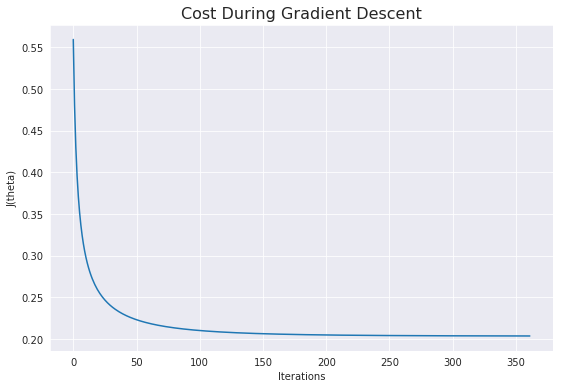

In [136]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(range(len(costs)), costs)
plt.title('Cost During Gradient Descent', fontsize=16)
plt.xlabel('Iterations')
plt.ylabel('J(theta)')
plt.show()

In [141]:
output = predict(X_scaled, theta_vals)
accuracy = (y == output['preds']).mean()
admit_percent = output['preds'].mean()

print('Prediction accuracy:\n{}'.format(accuracy))
print('\nPredicted admission percentage:\n{}'.format(admit_percent))

Prediction accuracy:
0.89

Predicted admission percentage:
0.61


## Plot Decision Boundary

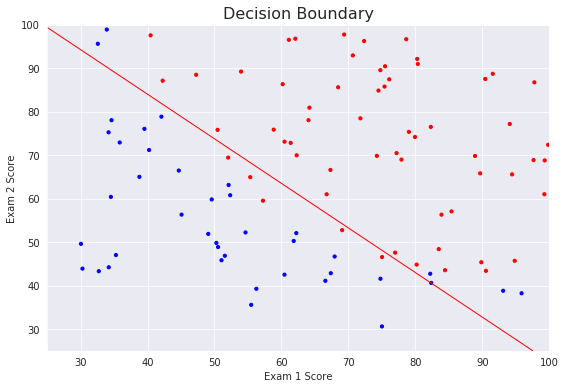

In [145]:
theta0_val_range = np.linspace(25,100,76)
theta1_val_range = np.linspace(25,100,76)
theta00, theta11 = np.meshgrid(theta0_val_range, theta1_val_range)
X_grid = np.column_stack((theta00.ravel(), theta11.ravel()))
grid_probs = scale_predict(X_grid, col_means, col_stdevs, theta_vals)['probs']

# Contour plot used to visually split predictions in half
fig, ax = plt.subplots(figsize=(9,6))
ax.contour(theta00, theta11, grid_probs.reshape(theta00.shape[0],-1), 1, 
           colors='red', linewidths=1)
ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr', s=10)
plt.xlim(25,100)
plt.ylim(25,100)
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.title('Decision Boundary', fontsize=16)
plt.show()

In [143]:
sample_student = np.array([[45, 85]])
scale_predict(sample_student, col_means, col_stdevs, theta_vals)

{'probs': array([0.76550123]), 'preds': array([1])}

# scikit-learn Implementation

For comparison, let's create a logistic regression classifier using scikit-learn and Pandas. In this case, I will use a standard train/test split.

In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_decision_regions

In [153]:
# Load dataset and split into X and y.
df = pd.read_csv(r'data/ex2data1.txt', names=['score1', 'score2', 'accepted'])
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

print(X_train.head())

       score1     score2
14  39.538339  76.036811
11  75.013658  30.603263
24  77.924091  68.972360
73  60.457886  73.094998
69  66.746719  60.991394


## Data Pipeline

In [154]:
# Create pipeline to perform feature scaling, fit model, and predict values.
pipe = Pipeline([('sc', StandardScaler()),('lr', LogisticRegression())])
pipe.fit(X_train, y_train)
predicted_probs_train = pipe.predict_proba(X_train)
predictions_train = pipe.predict(X_train)
accuracy = accuracy_score(y_train, predictions_train)
print(f'Training Accuracy: {accuracy:.2f}')

Training Accuracy: 0.88


In [155]:
preds_test = pipe.predict(X_test)
probs_test = pipe.predict_proba(X_test)
accuracy_test = accuracy_score(y_test, preds_test)
print(f'Test accuracy: {accuracy_test}')

Test accuracy: 0.96


In [156]:
print(f"Bias: {pipe.named_steps['lr'].intercept_[0]}")
print(f"Weights: {np.squeeze(pipe.named_steps['lr'].coef_)}")

Bias: 0.9947760289143478
Weights: [1.89826414 1.88518796]


## Additional Metrics

In [157]:
df_preds = pd.DataFrame(probs_test, columns=['p_reject', 'p_accept'])
# df_preds['p_reject'] = predicted_probs_train[:,0]
# df_preds['p_accept'] = predicted_probs_train[:,1]
df_preds['prediction'] = preds_test
df_preds['actual'] = y_test.values

# Calculate sensitivity and specificity.
tp = df_preds[(df_preds['prediction']==1) & (df_preds['actual']==1)].shape[0]
fp = df_preds[(df_preds['prediction']==1) & (df_preds['actual']==0)].shape[0]
tn = df_preds[(df_preds['prediction']==0) & (df_preds['actual']==0)].shape[0]
fn = df_preds[(df_preds['prediction']==0) & (df_preds['actual']==1)].shape[0]

sensitivity = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
df_preds.head(5)

Sensitivity: 1.0
Specificity: 0.92


,p_reject,p_accept,prediction,actual
0,0.153885,0.846115,1,1
1,0.541217,0.458783,0,0
2,0.024759,0.975241,1,1
3,0.013352,0.986648,1,1
4,0.909852,0.090148,0,0


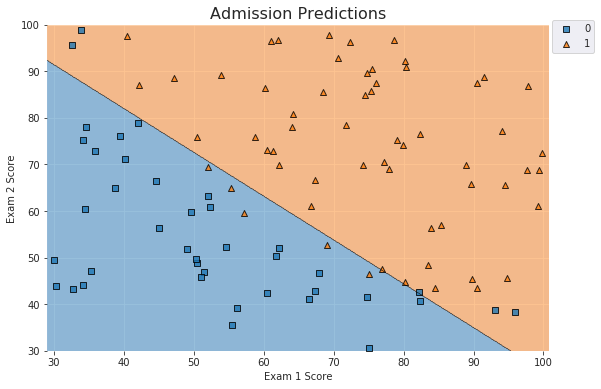

In [158]:
fig = plt.figure(figsize=(9,6))
plot_decision_regions(np.array(X), np.array(y), pipe)
plt.title('Admission Predictions', fontsize=16)
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.ylim(30,100)
plt.legend(bbox_to_anchor=(1.1,1.03))
plt.show()